# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---

## Run Pre-requisites

In [33]:
import numpy as np
from glob import glob

import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline      

from tqdm import tqdm

import torch
import torchvision.models as models

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    print("CUDA enabled!")
else: 
    print("NO CUDA!")
    
from PIL import Image
import torchvision.transforms as transforms

# Set PIL to be tolerant of image files that are truncated.
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import os
from torchvision import datasets
import torchvision

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

import random

# from PIL import ImageFile
# ImageFile.LOAD_TRUNCATED_IMAGES = True

CUDA enabled!


<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:
* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dogImages`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.


In [34]:
# import numpy as np
# from glob import glob

# load filenames for human and dog images
human_files = np.array(glob("lfw/lfw/*/*"))
dog_files = np.array(glob("dogImages/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


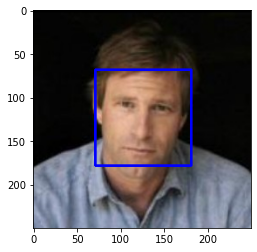

In [35]:
# import cv2                
# import matplotlib.pyplot as plt                        
# %matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [36]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 
(You can print out your results and/or write your percentages in this cell)

In [37]:
from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

#-#-# Do NOT modify the code above this line. #-#-#

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.

face_human_cnt = 0
for face in human_files_short:
    if face_detector(face):
        face_human_cnt = face_human_cnt + 1

print ("Percentage of human face in human files: ", face_human_cnt)

face_dog_cnt = 0
for face in dog_files_short:
    if face_detector(face):
        face_dog_cnt = face_dog_cnt + 1

print ("Percentage of human face in dog files: ", face_dog_cnt)

Percentage of human face in human files:  96
Percentage of human face in dog files:  18


We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [38]:
### (Optional) 
### TODO: Test performance of another face detection algorithm.
### Feel free to use as many code cells as needed.

#MAYBE WILL DO LATER

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [39]:
# import torch
# import torchvision.models as models

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
# use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    print("CUDA enabled!")
    VGG16 = VGG16.cuda()
else: 
    print("NO CUDA!")

CUDA enabled!


Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [40]:
# from PIL import Image
# import torchvision.transforms as transforms

# # Set PIL to be tolerant of image files that are truncated.
# from PIL import ImageFile
# ImageFile.LOAD_TRUNCATED_IMAGES = True

def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    image = Image.open(img_path)
    in_transform = transforms.Compose([transforms.Resize(224), 
                                       transforms.CenterCrop(224),                               
                                       transforms.ToTensor()])

    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = in_transform(image)[:3,:,:].unsqueeze(0)
    
    if use_cuda:
        image = image.cuda()
    
    output = VGG16(image)
    output = output.cpu()
    
    
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    
    return output.data.numpy().argmax() # predicted class index

### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [41]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    ## TODO: Complete the function.
    return 151 <= VGG16_predict(img_path) <= 268

### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 


In [42]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.

face_human_cnt = 0
for face in human_files_short:
    if dog_detector(face):
        face_human_cnt = face_human_cnt + 1

print ("Percentage of dog face in human files: ", face_human_cnt)

face_dog_cnt = 0
for face in dog_files_short:
    if dog_detector(face):
        face_dog_cnt = face_dog_cnt + 1

print ("Percentage of dog face in dog files: ", face_dog_cnt)

Percentage of dog face in human files:  0
Percentage of dog face in dog files:  93


We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).  Please use the code cell below to test other pre-trained PyTorch models.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [43]:
### (Optional) 
### TODO: Report the performance of another pre-trained network.
### Feel free to use as many code cells as needed.

#MAYBE DO LATER

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [44]:
# import os
# from torchvision import datasets
# import torchvision

### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
loaders_scratch = {}

transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.Resize((224,224)),
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

transform_valid = transforms.Compose([
    transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

transform_test = transforms.Compose([
    transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

train_data = torchvision.datasets.ImageFolder('./dogImages/train/', transform=transform_train)
valid_data = torchvision.datasets.ImageFolder('./dogImages/valid/', transform=transform_valid)
test_data = torchvision.datasets.ImageFolder('./dogImages/test/', transform=transform_test)

# prepare data loaders (combine dataset and sampler
num_workers = 0
batch_size = 40

loaders_scratch['train'] = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
loaders_scratch['valid'] = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
loaders_scratch['test'] = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

**Question 3:** Describe your chosen procedure for preprocessing the data. 
1. How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
1. Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


**Answer**:

1. Code resizes images by resizing it into simple image of 224 x 224. I picked the size of 224 x 224 because it's a good number to divide by 2 (due to the 2-sezed max pooling layer) by going 5 layers deep. I initially had it sized to 200x200, but this was only good when I decided to only used 3 convulutional layers. 224 divides by 2 into whole numbers, 5 times over. 200 does not.

1. Yes, I augmented the dataset. I did a Random horizontal flip to flip some images upside down. I also rotated random images by 10 degrees. Adding image augmentation allowed for my model to train better.

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [45]:
# import torch.nn as nn
# import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        
        # convolutional layer (sees 224x224x3 image tensor)
        self.conv1 = nn.Conv2d(3, 16, (3,3), padding=1)
        self.conv2 = nn.Conv2d(16, 32, (3,3), padding=1)
        self.conv3 = nn.Conv2d(32, 64, (3,3), padding=1)
        self.conv4 = nn.Conv2d(64, 128, (3,3), padding=1)
        self.conv5 = nn.Conv2d(128, 256, (3,3), padding=1)
        
        self.batch_norm2d1 = nn.BatchNorm2d(16)
        self.batch_norm2d2 = nn.BatchNorm2d(32)
        self.batch_norm2d3 = nn.BatchNorm2d(64)
        self.batch_norm2d4 = nn.BatchNorm2d(128)
        self.batch_norm2d5 = nn.BatchNorm2d(256)
        
        # max pooling layer 
        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(256 * 7 * 7, 512)
        # self.fc2 = nn.Linear(2048, 512)
        self.fc3 = nn.Linear(512, 133)
 
        self.dropout = nn.Dropout(0.3)
    
    def forward(self, x):
        ## Define forward behavior
                # add sequence of convolutional and max pooling layers
            
        x = self.pool(self.batch_norm2d1(F.relu(self.conv1(x))))
        x = self.pool(self.batch_norm2d2(F.relu(self.conv2(x))))
        x = self.pool(self.batch_norm2d3(F.relu(self.conv3(x))))
        x = self.pool(self.batch_norm2d4(F.relu(self.conv4(x))))
        x = self.pool(self.batch_norm2d5(F.relu(self.conv5(x))))
        
        # flatten image input
        x = x.view(-1, 256 * 7 * 7)
        
        # add dropout layer
        x = self.dropout(x)
        
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        
        # add dropout layer
        x = self.dropout(x)

        # x = F.relu(self.fc2(x))
        # x = self.dropout(x)
        
        # add 3rd and final hidden layer, with relu activation function
        x = self.fc3(x)
        
        return x

#-#-# You do NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()
print(model_scratch)

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (batch_norm2d1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm2d2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm2d3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm2d4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm2d5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_feature

__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__ 

I initially had 3 convolutional layers. But I kept getting a high training & validation loss and less than 10% accuracy. So I increased the number of convolutional layers to 5. Keeping it simple. 

Each of my convolutional layers have a ReLu activation and is also Batch-Normalized.

I applied a max pooling layer to remove a lot of the spacial/blank content in the images and kept it 2-sized, so each subsequent convolutional layers was deepened by a factor of 2.

Originally there were 3 fully-connected layers, but I shrunk this to 2, in the hope of it speeding up the training. Made sure that each fully-connected layer at a reasonable dropout rate, I increased by dropout from 0.25 to 0.3 after the accuracy was not reaching 10%



### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [46]:
# import torch.optim as optim

### TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

### TODO: select optimizer
optimizer_scratch = optim.SGD(model_scratch.parameters(), lr=0.01)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [47]:
# the following import is required for training to be robust to truncated images
# from PIL import ImageFile
# ImageFile.LOAD_TRUNCATED_IMAGES = True

def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss

            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            
                    # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            valid_loss += ((1 / (batch_idx + 1)) * (loss.item() - valid_loss))

            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss

    # return trained model
    return model




In [ ]:
print("Starting to run Training...")

# train the model
model_scratch = train(50, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

Starting to run Training...
Epoch: 1 	Training Loss: 4.905218 	Validation Loss: 4.863996
Validation loss decreased (inf --> 4.863996).  Saving model ...
Epoch: 2 	Training Loss: 4.858927 	Validation Loss: 4.812848
Validation loss decreased (4.863996 --> 4.812848).  Saving model ...
Epoch: 3 	Training Loss: 4.811013 	Validation Loss: 4.758449
Validation loss decreased (4.812848 --> 4.758449).  Saving model ...
Epoch: 4 	Training Loss: 4.766476 	Validation Loss: 4.707694
Validation loss decreased (4.758449 --> 4.707694).  Saving model ...
Epoch: 5 	Training Loss: 4.713834 	Validation Loss: 4.652073
Validation loss decreased (4.707694 --> 4.652073).  Saving model ...
Epoch: 6 	Training Loss: 4.666286 	Validation Loss: 4.607227
Validation loss decreased (4.652073 --> 4.607227).  Saving model ...
Epoch: 7 	Training Loss: 4.622318 	Validation Loss: 4.553889
Validation loss decreased (4.607227 --> 4.553889).  Saving model ...
Epoch: 8 	Training Loss: 4.584436 	Validation Loss: 4.530330
Valida

In [17]:
print("Starting to run Training...")

# train the model
model_scratch = train(50, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch1.pt')


Starting to run Training...
Epoch: 1 	Training Loss: 3.943114 	Validation Loss: 4.218523
Validation loss decreased (inf --> 4.218523).  Saving model ...
Epoch: 2 	Training Loss: 3.926667 	Validation Loss: 4.137409
Validation loss decreased (4.218523 --> 4.137409).  Saving model ...
Epoch: 3 	Training Loss: 3.891503 	Validation Loss: 4.189016
Epoch: 4 	Training Loss: 3.874516 	Validation Loss: 4.127441
Validation loss decreased (4.137409 --> 4.127441).  Saving model ...
Epoch: 5 	Training Loss: 3.875815 	Validation Loss: 4.096216
Validation loss decreased (4.127441 --> 4.096216).  Saving model ...
Epoch: 6 	Training Loss: 3.846002 	Validation Loss: 4.178371
Epoch: 7 	Training Loss: 3.849487 	Validation Loss: 4.110947
Epoch: 8 	Training Loss: 3.841469 	Validation Loss: 4.151195
Epoch: 9 	Training Loss: 3.822735 	Validation Loss: 4.131289
Epoch: 10 	Training Loss: 3.796408 	Validation Loss: 4.141471
Epoch: 11 	Training Loss: 3.787438 	Validation Loss: 4.189986
Epoch: 12 	Training Loss: 3.

KeyboardInterrupt: 

In [20]:
#added RandomVerticalFlip() & increase CropRotation to 15, decreased learning rate to 0.0005

print("Starting to run Training...")

model_scratch = train(50, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch2.pt')


Starting to run Training...
Epoch: 1 	Training Loss: 3.923243 	Validation Loss: 4.223671
Validation loss decreased (inf --> 4.223671).  Saving model ...
Epoch: 2 	Training Loss: 3.895845 	Validation Loss: 4.154467
Validation loss decreased (4.223671 --> 4.154467).  Saving model ...
Epoch: 3 	Training Loss: 3.864497 	Validation Loss: 4.121071
Validation loss decreased (4.154467 --> 4.121071).  Saving model ...
Epoch: 4 	Training Loss: 3.877585 	Validation Loss: 4.279125
Epoch: 5 	Training Loss: 3.817214 	Validation Loss: 4.204423
Epoch: 6 	Training Loss: 3.847176 	Validation Loss: 4.310557
Epoch: 7 	Training Loss: 3.826981 	Validation Loss: 4.227935
Epoch: 8 	Training Loss: 3.792021 	Validation Loss: 4.201665
Epoch: 10 	Training Loss: 3.771471 	Validation Loss: 4.300386
Epoch: 11 	Training Loss: 3.780827 	Validation Loss: 4.354345
Epoch: 12 	Training Loss: 3.765093 	Validation Loss: 4.358360
Epoch: 13 	Training Loss: 3.765488 	Validation Loss: 4.263192


KeyboardInterrupt: 

In [15]:
#removedRandomVerticalFlip() & decerased crop 10,, increase to 0.01, batch to 40

print("Starting to run Training...")

model_scratch = train(50, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch3.pt')


Starting to run Training...
Epoch: 1 	Training Loss: 4.799747 	Validation Loss: 4.582507
Validation loss decreased (inf --> 4.582507).  Saving model ...
Epoch: 2 	Training Loss: 4.563619 	Validation Loss: 4.462046
Validation loss decreased (4.582507 --> 4.462046).  Saving model ...
Epoch: 3 	Training Loss: 4.415207 	Validation Loss: 4.363332
Validation loss decreased (4.462046 --> 4.363332).  Saving model ...
Epoch: 4 	Training Loss: 4.314098 	Validation Loss: 4.336278
Validation loss decreased (4.363332 --> 4.336278).  Saving model ...
Epoch: 5 	Training Loss: 4.229287 	Validation Loss: 4.262754
Validation loss decreased (4.336278 --> 4.262754).  Saving model ...
Epoch: 6 	Training Loss: 4.157555 	Validation Loss: 4.232184
Validation loss decreased (4.262754 --> 4.232184).  Saving model ...
Epoch: 7 	Training Loss: 4.093259 	Validation Loss: 4.139682
Validation loss decreased (4.232184 --> 4.139682).  Saving model ...
Epoch: 8 	Training Loss: 4.015196 	Validation Loss: 4.148940
Epoch:

KeyboardInterrupt: 

**All models are saved in https://github.com/bnagallo/DL2-dog-breed-classifier**

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

**model_scratch3.pt provided the higher accuracy**

In [45]:
# load the model that got the best validation accuracy
## model_scratch3.pt provided the higher accuracy
model_scratch_to_use = 'model_scratch3.pt'

# move model to GPU if CUDA is available
if use_cuda:
    map_loc = torch.device('cuda')
else: 
    map_loc = torch.device('cpu')
    

model_scratch.load_state_dict(torch.load(model_scratch_to_use, map_location=map_loc))

def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 3.725581


Test Accuracy: 17% (148/836)


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [48]:
## TODO: Specify data loaders
loaders_transfer = {}

loaders_transfer['train'] = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
loaders_transfer['valid'] = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, num_workers=num_workers)
loaders_transfer['test'] = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

# Visualize some sample data

# obtain one batch of training images
dataiter = iter(loaders_transfer['train'])
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display


### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [49]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)

# print out the model structure
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [50]:
print(vgg16.classifier[6].in_features) 
print(vgg16.classifier[6].out_features) 

4096
1000


In [51]:
# Freeze training for all "features" layers
for param in vgg16.features.parameters():
    param.requires_grad = False
    
import torch.nn as nn

n_inputs = vgg16.classifier[6].in_features

# add last linear layer (n_inputs -> 5 flower classes)
# new layers automatically have requires_grad = True
last_layer = nn.Linear(n_inputs, 133)

vgg16.classifier[6] = last_layer

# if GPU is available, move the model to GPU
if use_cuda:
    model_transfer = vgg16.cuda()
else: model_transfer = vgg16

# check to see that your last layer produces the expected number of outputs
print(vgg16.classifier[6].out_features)

133


In [52]:
if use_cuda:
    model_transfer = model_transfer.cuda()
print(model_transfer)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 


I used the VGG16 model and downloaded a pre-trained model to use. I Froze all the parameters in order for the network to be a fixed feature extractor. I removed the last layer and replaced it with my my own, specifically one that outputs to 133 classes (dog breeds).

After I've defined the model. I trained it with the same data loaders from the scratch model. When tested, it can reach ~73& accuracy after only 10 epochs with a starting training/validation loss a lot smaller seen from the scratch model.

This architecture is appropriate for this use case, because the new data set of dogs is small compared to the large data sets seen in MNIST and CIFAR databases. Also the new data is similar to the original training data since the VGG16 model has already classified dog breeds in their previous labels. Most of the all the pre-trained neural network layers already contain relevant info about the dogs data set and therefore should just be kept the same.

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [53]:
# specify loss function (categorical cross-entropy)
criterion_transfer = nn.CrossEntropyLoss()

# specify optimizer (stochastic gradient descent) and learning rate = 0.01
optimizer_transfer = optim.SGD(vgg16.classifier.parameters(), lr=0.01)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [54]:
# train the model

def transfer_train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss

            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            
                    # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            valid_loss += ((1 / (batch_idx + 1)) * (loss.item() - valid_loss))

            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss

    # return trained model
    return model



# load the model that got the best validation accuracy (uncomment the line below)
#model_transfer.load_state_dict(torch.load('model_transfer.pt'))

### Call Train Function on Transfer Model

In [17]:
print("Starting transfer model training...")

model_transfer = transfer_train(50, loaders_transfer, model_transfer, 
                                optimizer_transfer, 
                                criterion_transfer, use_cuda, 
                                'model_transfer.pt')

Starting transfer model training...
Epoch: 1 	Training Loss: 2.612069 	Validation Loss: 1.249650
Validation loss decreased (inf --> 1.249650).  Saving model ...
Epoch: 2 	Training Loss: 1.287699 	Validation Loss: 1.059184
Validation loss decreased (1.249650 --> 1.059184).  Saving model ...
Epoch: 3 	Training Loss: 1.097207 	Validation Loss: 0.988488
Validation loss decreased (1.059184 --> 0.988488).  Saving model ...
Epoch: 4 	Training Loss: 1.014234 	Validation Loss: 0.959716
Validation loss decreased (0.988488 --> 0.959716).  Saving model ...
Epoch: 5 	Training Loss: 0.930831 	Validation Loss: 0.915913
Validation loss decreased (0.959716 --> 0.915913).  Saving model ...
Epoch: 6 	Training Loss: 0.941943 	Validation Loss: 0.917378
Epoch: 7 	Training Loss: 0.886062 	Validation Loss: 0.895360
Validation loss decreased (0.915913 --> 0.895360).  Saving model ...
Epoch: 8 	Training Loss: 0.826132 	Validation Loss: 0.891165
Validation loss decreased (0.895360 --> 0.891165).  Saving model ..

In [113]:
print("Starting transfer model training...")

model_transfer = transfer_train(10, loaders_transfer, model_transfer, 
                                optimizer_transfer, 
                                criterion_transfer, use_cuda, 
                                'model_transfer1.pt')

Starting transfer model training...
Epoch: 1 	Training Loss: 0.669879 	Validation Loss: 0.895747
Validation loss decreased (inf --> 0.895747).  Saving model ...
Epoch: 2 	Training Loss: 0.631892 	Validation Loss: 0.893122
Validation loss decreased (0.895747 --> 0.893122).  Saving model ...
Epoch: 3 	Training Loss: 0.629284 	Validation Loss: 0.915816
Epoch: 4 	Training Loss: 0.623500 	Validation Loss: 0.882824
Validation loss decreased (0.893122 --> 0.882824).  Saving model ...
Epoch: 5 	Training Loss: 0.625491 	Validation Loss: 0.913049
Epoch: 6 	Training Loss: 0.627044 	Validation Loss: 0.906527
Epoch: 7 	Training Loss: 0.599254 	Validation Loss: 0.882334
Validation loss decreased (0.882824 --> 0.882334).  Saving model ...
Epoch: 8 	Training Loss: 0.603733 	Validation Loss: 0.895617
Epoch: 9 	Training Loss: 0.585695 	Validation Loss: 0.903901
Epoch: 10 	Training Loss: 0.595408 	Validation Loss: 0.923503


### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [21]:
# load the model that got the best validation accuracy

model_transfer_to_use = 'model_transfer.pt'

# move model to GPU if CUDA is available
if use_cuda:
    map_loc_transfer = torch.device('cuda')
else: 
    map_loc_transfer = torch.device('cpu')
    
# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load(model_transfer_to_use, 
                                          map_location=map_loc_transfer))

def test_transfer(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

test_transfer(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.923244


Test Accuracy: 73% (617/836)


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [55]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in train_data.classes]

def predict_breed_transfer(img_path):
    
    image = Image.open(img_path)
    in_transform = transforms.Compose([transforms.Resize(224), 
                                       transforms.CenterCrop(224),                               
                                       transforms.ToTensor()])

    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = in_transform(image)[:3,:,:].unsqueeze(0)
    
    if use_cuda:
        image = image.cuda()
    
    output = model_transfer(image)
    
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy()) if not use_cuda else np.squeeze(preds_tensor.cpu().numpy())

    return class_names[preds]

---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

#### Make a Display Image helper function

In [56]:
def display_img(img_path, title, caption):
    
    print('\n\n\n\nHello ', title)
    print(caption)
    
    img = cv2.imread(img_path)
    # convert BGR image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # convert BGR image to RGB for plotting
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # display the image, along with bounding box
    plt.imshow(cv_rgb)
    plt.show()

#### Run App function

In [57]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

def run_app(img_path):

    if dog_detector(img_path):
        display_img(img_path, 'Pup', 'You are this dog breed: ' + 
                    predict_breed_transfer(img_path))
    elif face_detector(img_path):
        display_img(img_path, 'Human', 'You look like this dog breed: ' + 
                    predict_breed_transfer(img_path))
    else:
        display_img(img_path, '', 'You are neither Human, nor Dog')

---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)

I am quite impressed with the modelling 

From various iterations of randomizing the bottom cell, I can see that that the human and dog detector is more than accurate, with very errors displaying.

The algorithm correctly predicts if the subject is Human, Dog, or neither. It throws an error for an image of an Alien and Cat.

The Dog Breed detector that used transfer learning is a lot more accurate than the scratch model by a large degree. Although the dog breed detector is sometimes inaccurate, but it comes VERY close and could use some improvement. The first dog image that I predicted said it was a *Havanese*, however plugging the dog into Google's search returns that it's a *Bearded Collie*. But these 2 breeds look very close to each other.

This is still a very large improvement from the expected scratch model, and with more training of the transfer model could yield better results.

Some possible points for improvement are:

1. Get more images of dogs to train so the model can train on more selections, especially for dogs that look similar. In the bottom cell, the first dog does not look like a *Canaan Dog*.
1. Augment the dog training set even more, one thing I'd like to try is squishing the data. I see some dog images with multiple dogs, also some dogs with humans... which might not have been trained too well.
1. Try another pre-trained model, maybe the VGG19 model, which has more layers would provide more accurate weights and be more accurate. There is also ResNet50 and EfficientNet to try.
1. Also, I would like to try a different optimizer as well. I've used only SGD, but maybe an Adam optimizer would produce better accuracy.

**Get 2 images that are not Dog, nor Alien**

In [58]:
# load filenames for random images of ALIEN and CAT
random_files = np.array(glob("testImages/*"))
print(list(random_files))

['testImages\\alien.jpg', 'testImages\\cat.png']


#### Test of 6 different images:
2 images of Humans, 2 images of Dogs, 2 images of neigter Human, nor Dog





Hello  Human
You look like this dog breed: Chinese crested


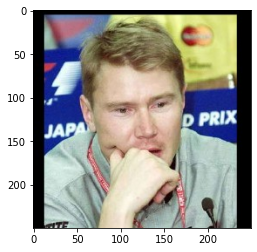





Hello  Human
You look like this dog breed: Pharaoh hound


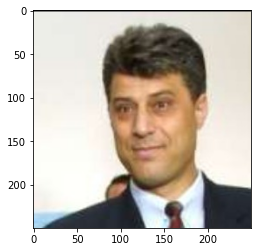





Hello  Pup
You are this dog breed: Havanese


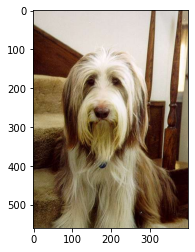





Hello  Pup
You are this dog breed: Bouvier des flandres


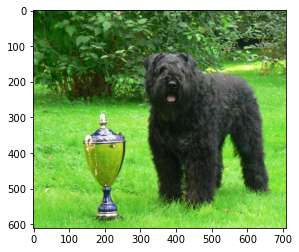





Hello  
You are neither Human, nor Dog


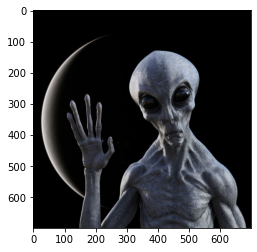





Hello  
You are neither Human, nor Dog


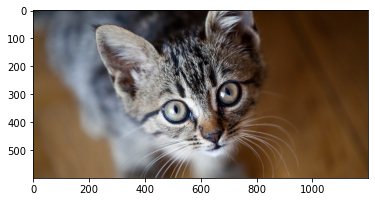

In [32]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

# Get any 2 dogs
dogs_randnums= np.random.randint(0,len(dog_files),2)
dogs_accessed_mapping = map(dog_files.__getitem__, dogs_randnums)
dogs_accessed_list = list(dogs_accessed_mapping)

# Get any 2 humans
humans_randnums= np.random.randint(0,len(human_files),2)
humans_accessed_mapping = map(human_files.__getitem__, humans_randnums)
humans_accessed_list = list(humans_accessed_mapping)

# suggested code, below
for file in (humans_accessed_list + dogs_accessed_list + list(random_files) ):
    run_app(file)